In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

commodities = ['Maize', 'Wheat', 'Oats', 'Soybeans']
DATA_PATH = '/kaggle/input/processed-data' # Remove the /kaggle/input prefix for reproducing the results
Y_COLUMN = 'Sep'

In [2]:
commodities_datasets = []
for commodity in commodities:
    dataset = pd.read_csv(f'{DATA_PATH}/full_{commodity}.csv')
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset = dataset[['Date', Y_COLUMN]]
    commodities_datasets.append(dataset)

1311


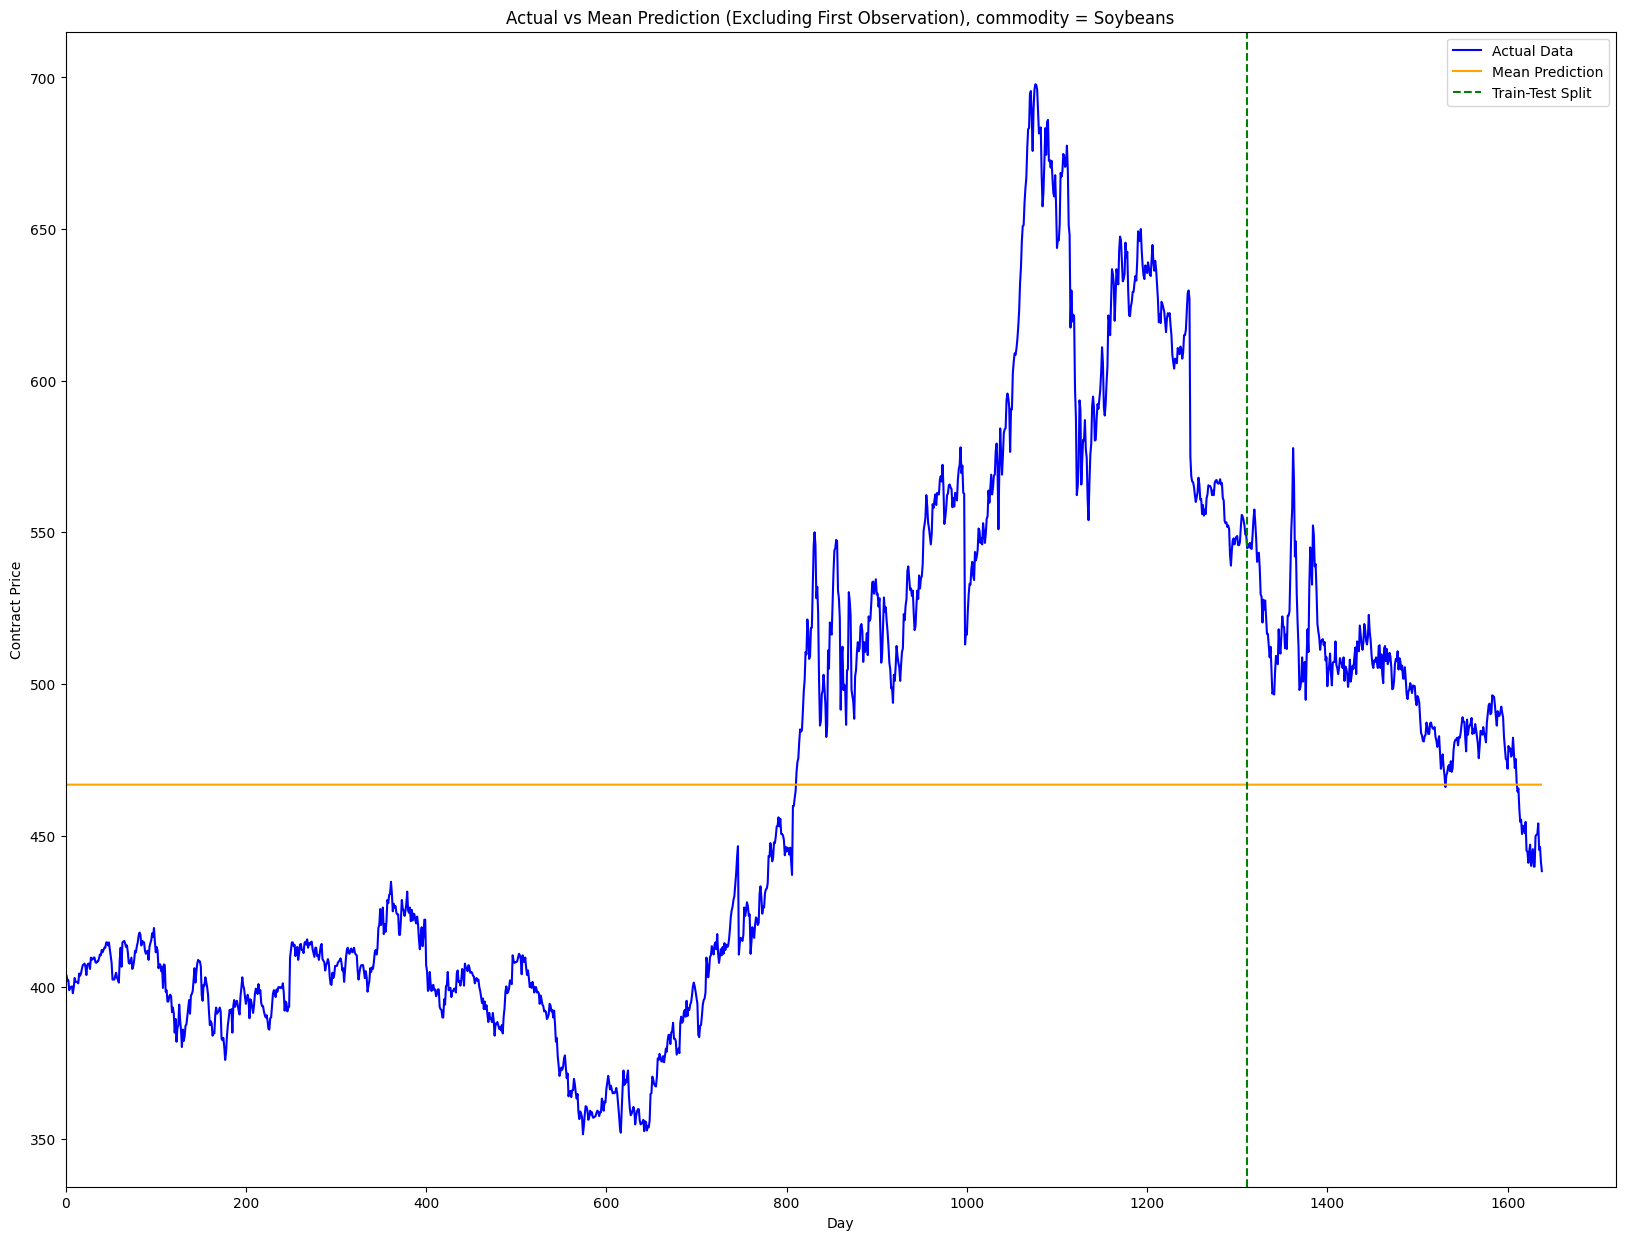

1273


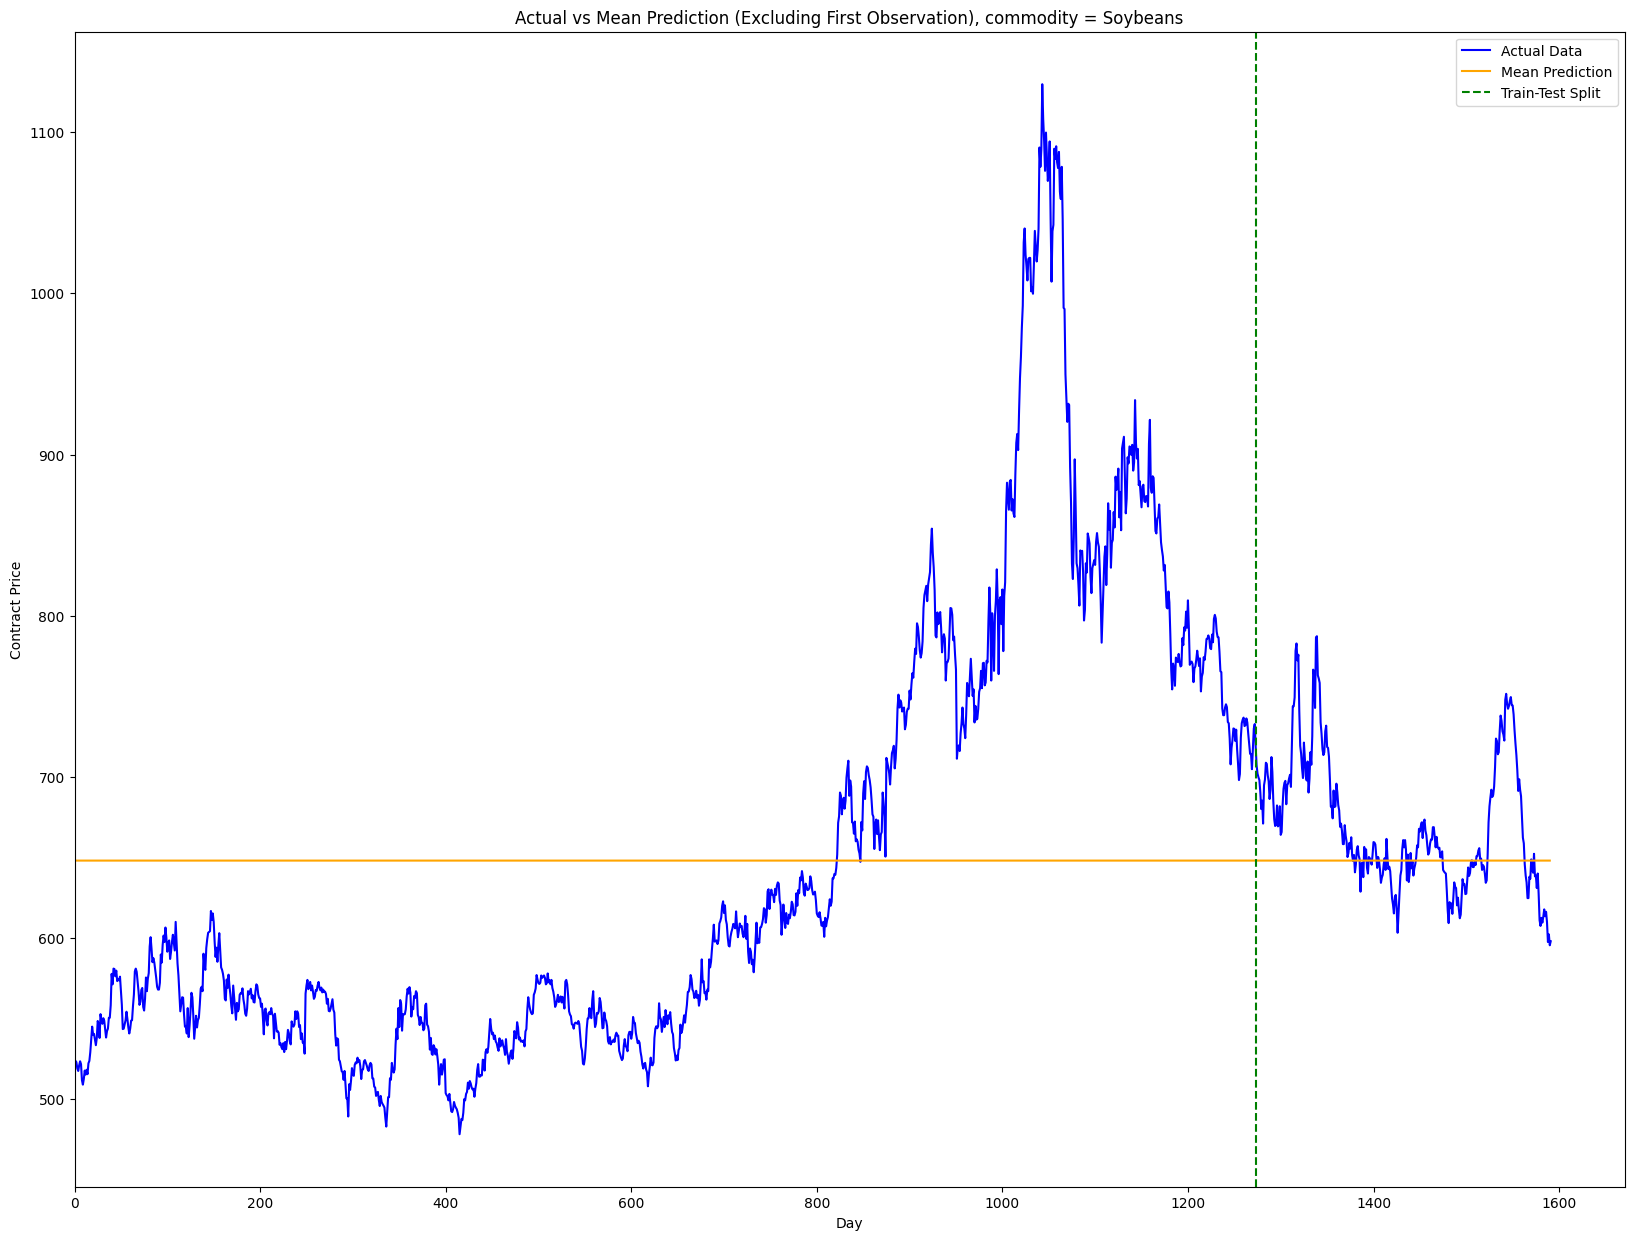

1312


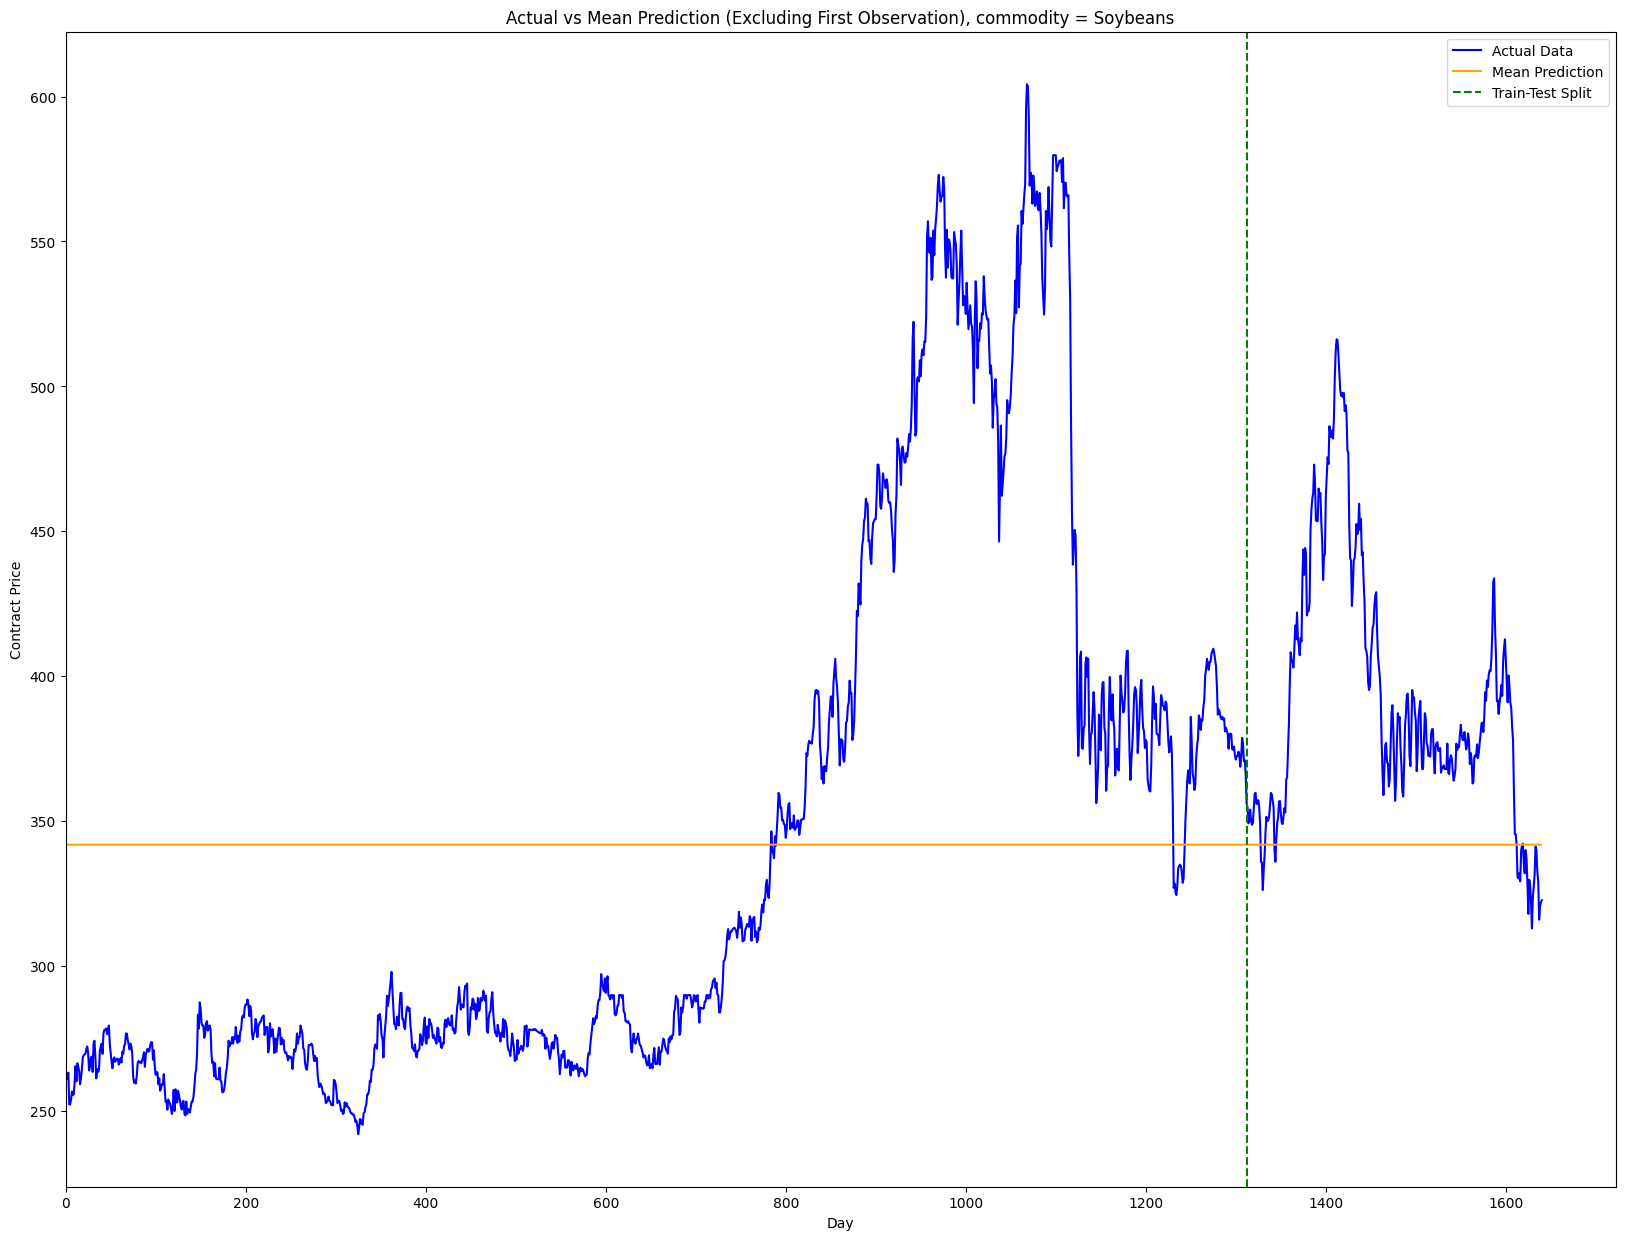

1312


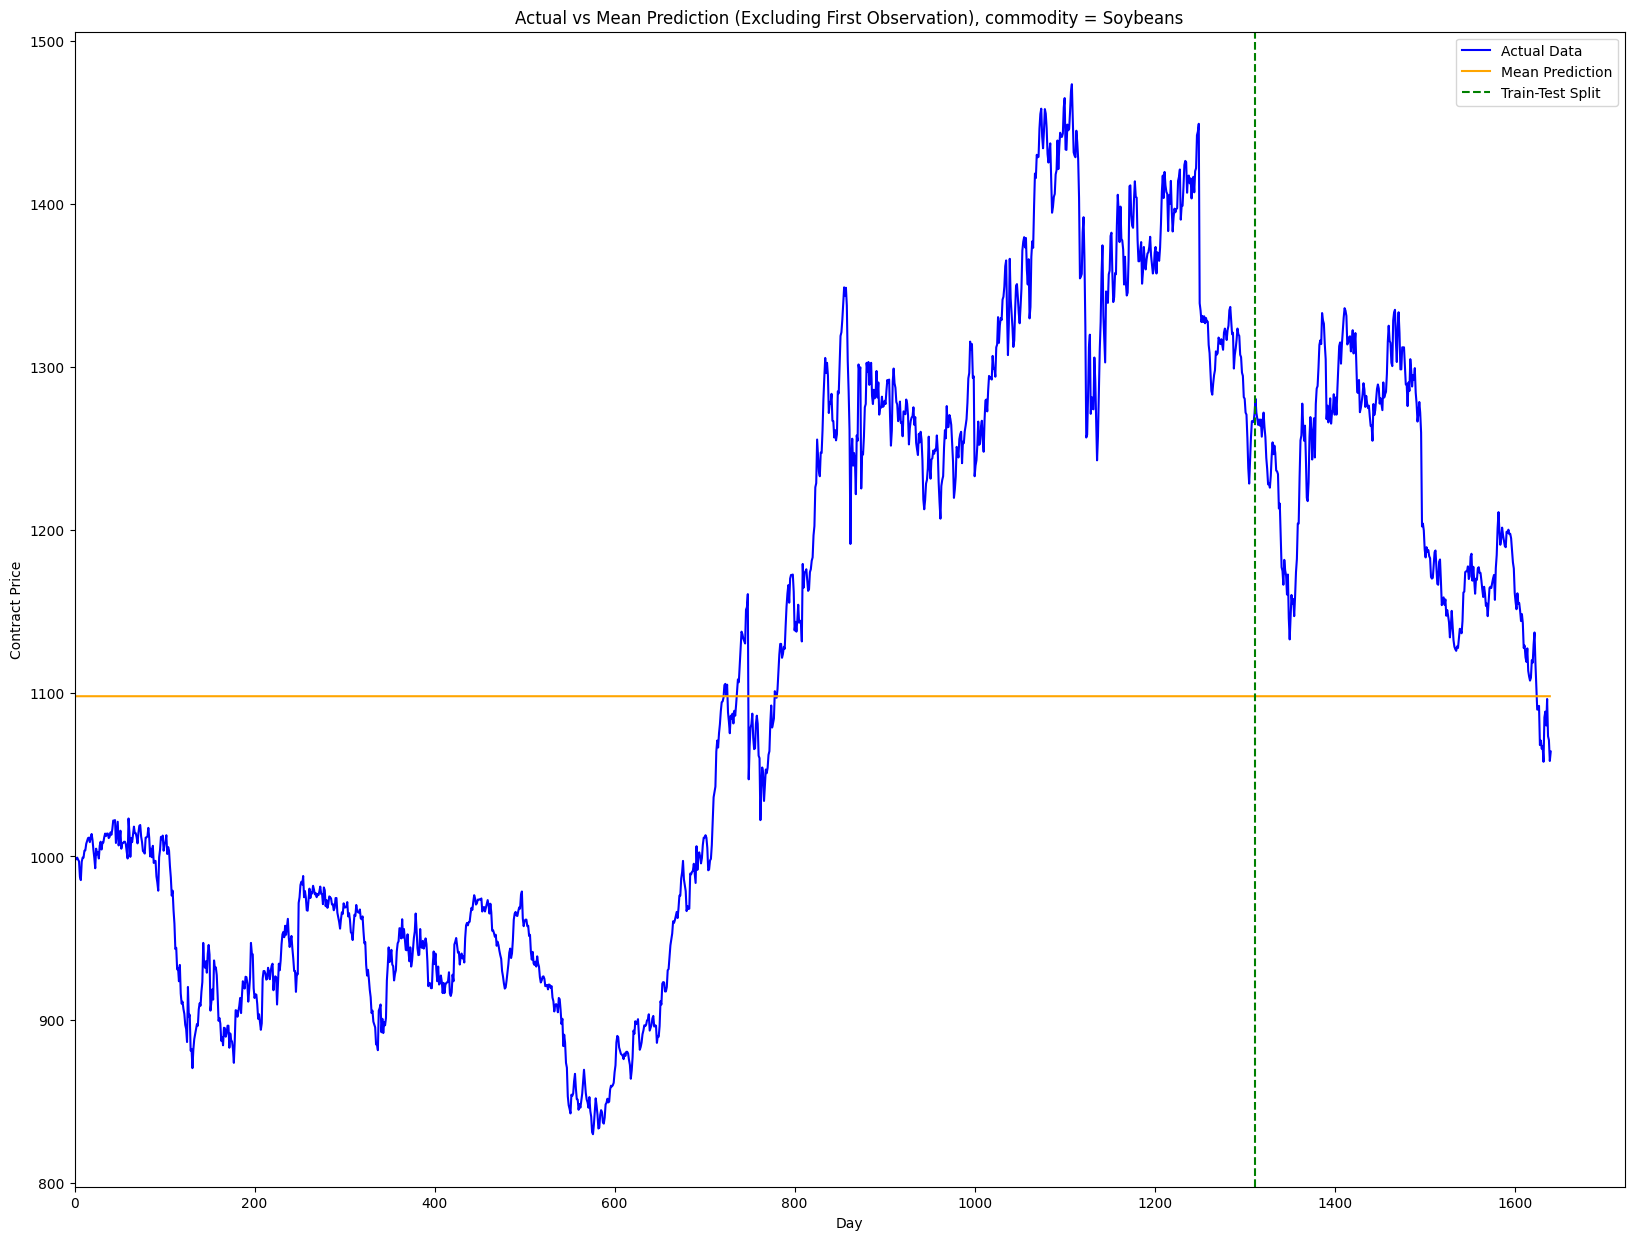

In [3]:

all_train_rmse = []
all_test_rmse = []
for i in range(len(commodities_datasets)):
    split_index = int(len(commodities_datasets[i]) * 0.8)
    print(split_index)
    train_df = commodities_datasets[i].iloc[:split_index]
    test_df = commodities_datasets[i].iloc[split_index:]
    assert len(commodities_datasets[i]) == len(train_df) + len(test_df)
    
    avg_train = train_df[Y_COLUMN].mean()
    sep_train_array = train_df[Y_COLUMN].to_numpy()
    sep_test_array = test_df[Y_COLUMN].to_numpy()
    
    avg_train_array = np.full(len(sep_train_array), avg_train)
    avg_test_array = np.full(len(sep_test_array), avg_train)
    
    #In order to be compatible with the experiments of SARIMA and Holt Winters
    #We will consider only from the second observation and so on (because we can't predict the first one)
    training_rmse = (((sep_train_array[1:] - avg_train_array[1:]) ** 2).mean())**0.5
    test_rmse = (((sep_test_array - avg_test_array) ** 2).mean())**0.5
    
    all_train_rmse.append(training_rmse)
    all_test_rmse.append(test_rmse)
    
    #Plotting the fitting graphs
    plt.figure(figsize=(20, 15))
    plt.plot(commodities_datasets[i][1:][Y_COLUMN], label='Actual Data', color='blue')

    plt.plot(np.full(len(commodities_datasets[i])-1, avg_train), label='Mean Prediction', color='orange')
    plt.axvline(x=split_index, color='green', linestyle='--', label='Train-Test Split')
    plt.xlabel('Day')
    plt.ylabel('Contract Price')
    plt.title(f'Actual vs Mean Prediction (Excluding First Observation), commodity = {commodities[3]}')
    plt.legend()
    plt.xlim(0,)

    plt.show()
    





## Comparison of all RMSE losses, across all commodities (train and test)

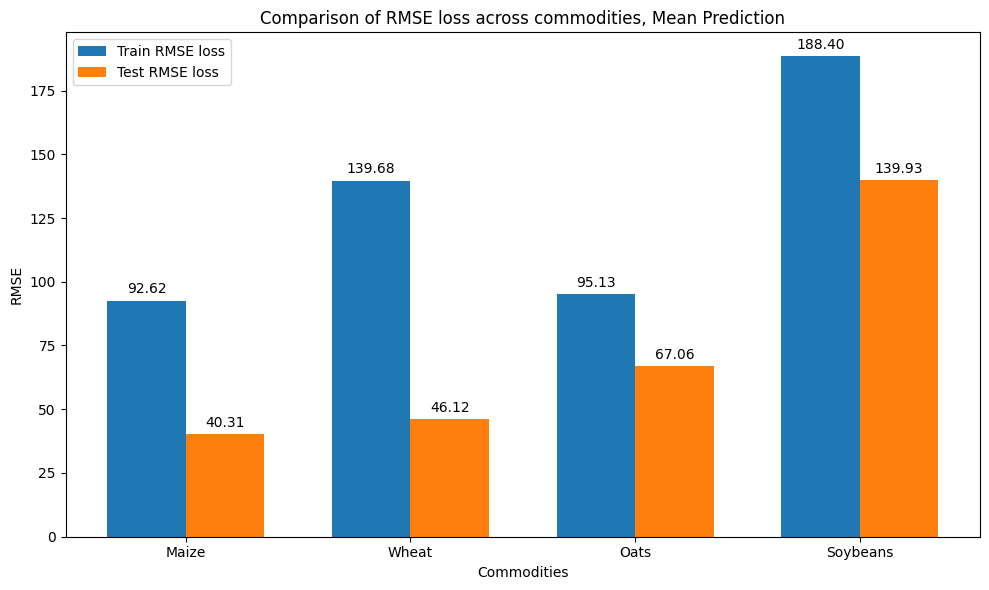

In [4]:
n_commodities = len(commodities)
ind = np.arange(n_commodities)  # the x locations for the commodities
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
train_bars = ax.bar(ind - width/2, all_train_rmse, width, label='Train RMSE loss')
test_bars = ax.bar(ind + width/2, all_test_rmse, width, label='Test RMSE loss')

ax.set_xlabel('Commodities')
ax.set_ylabel('RMSE')
ax.set_title('Comparison of RMSE loss across commodities, Mean Prediction')
ax.set_xticks(ind)
ax.set_xticklabels(commodities)
ax.legend()

# Function to add labels above the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(train_bars)
add_labels(test_bars)
plt.tight_layout()
plt.show()


---------------

## Summarization

From the results above, we can see that the training RMSE is larger than the test RMSE. This is reasonable because, near the point where the split between the train and test sets was made, the trend in the training data became very similar to that of the test data. The contract prices appear to rise, which aligns with the general trend in the test set, where prices are higher than in the earlier days of the training set.

However, the results are worse overall when compared to SARIMA, as the RMSE is larger in every type of commodity, both in the training and test sets. In some commodities, the difference in the test set is more pronounced (such as in Soybeans, where the Mean Prediction is three times worse than SARIMA's), but in the case of Wheat, the results are nearly the same.

